In [1]:
import numpy as np
import matplotlib.pyplot as plt
from monkey.config import TrainingIOConfig
from monkey.data.dataset import get_classification_dataloaders
from monkey.model.classification_model.efficientnet_b0 import (
    EfficientNet_B0,
)
from sklearn import metrics
from pprint import pprint
from monkey.model.utils import get_classification_metrics
import torch
from tqdm.autonotebook import tqdm
from monkey.data.data_utils import imagenet_denormalise

/home/u1910100/miniconda3/envs/tiatoolbox/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = EfficientNet_B0(
    input_channels=3, num_classes=1, pretrained=False
)
# model = smp.Unet(
#     encoder_name="mit_b5",
#     encoder_weights=None,
#     decoder_attention_type="scse",
#     in_channels=3,
#     classes=1,
# )

val_fold = 1

checkpoint_path = f"/home/u1910100/Documents/Monkey/runs/cls/efficientnetb0/fold_{val_fold}/epoch_4.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model"])
model.eval()
model.to("cuda")

IOconfig = TrainingIOConfig(
    dataset_dir="/home/u1910100/Documents/Monkey/classification",
    save_dir=f"./",
)
IOconfig.set_image_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)
IOconfig.set_mask_dir(
    "/home/u1910100/Documents/Monkey/classification/patches"
)

# Get dataloaders for task
train_loader, val_loader = get_classification_dataloaders(
    IOconfig,
    val_fold=val_fold,
    batch_size=32,
    do_augmentation=False,
    stack_mask=False,
)

[55569, 28763]
train patches: 84332
test patches: 28111


100%|██████████| 879/879 [00:33<00:00, 26.53it/s]


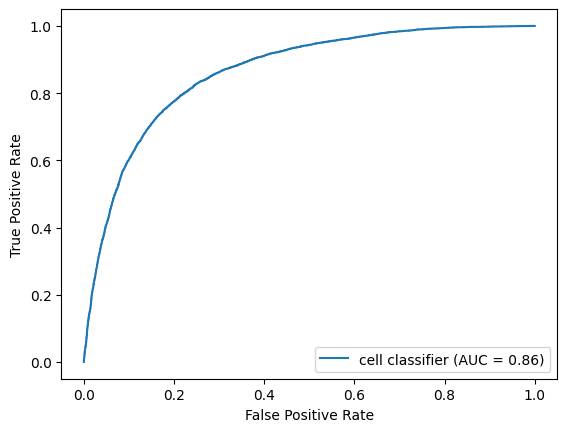

In [3]:
visualization = False
pred_probs_list = []
true_labels_list = []

for data in tqdm(val_loader):
    file_ids = data["id"]

    images, true_labels = (
        data["image"].cuda().float(),
        data["label"].cpu().tolist(),
    )

    true_labels_list.extend(true_labels)

    image_np = images[0]
    image_np = image_np.cpu().numpy()

    image_np = np.moveaxis(image_np, 0, 2)
    image_np = imagenet_denormalise(image_np)

    with torch.no_grad():
        logits_pred = model(images)
        pred_probs = torch.sigmoid(logits_pred)

    pred_probs = torch.squeeze(pred_probs)
    pred_probs = pred_probs.cpu().tolist()
    pred_probs_list.extend(pred_probs)


pred_probs_list = np.array(pred_probs_list)
true_labels_list = np.array(true_labels_list)
fpr, tpr, thresholds = metrics.roc_curve(
    true_labels_list, pred_probs_list
)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr,
    tpr=tpr,
    roc_auc=roc_auc,
    estimator_name="cell classifier",
)
display.plot()
plt.show()

0.6
{'Balanced_Accuracy': 0.7880977180868913,
 'F1': 0.7173128088179399,
 'Precision': 0.6587260034904014,
 'Recall': 0.7873383395911556}


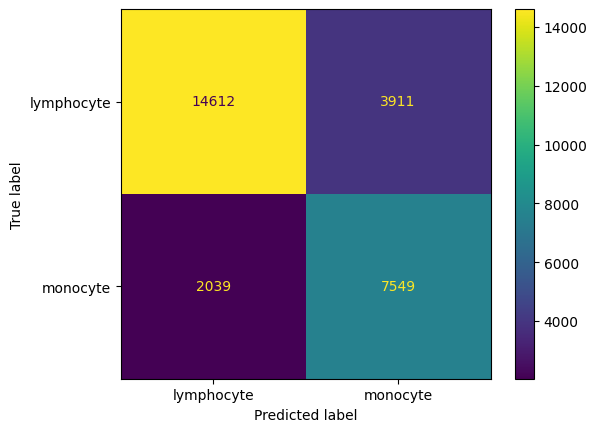

In [5]:
thresholds = [
    # 0.4,
    # 0.5,
    # 0.55,
    0.6,
    # 0.65,
    # 0.7,
]
for thresh in thresholds:
    # thresh = 0.5
    pred_labels_list = np.where(pred_probs_list > thresh, 1, 0)
    scores = get_classification_metrics(
        true_labels_list, pred_labels_list
    )
    pprint(thresh)
    pprint(scores)
metrics.ConfusionMatrixDisplay.from_predictions(
    true_labels_list,
    pred_labels_list,
    display_labels=["lymphocyte", "monocyte"],
)
plt.show()